*** 1. Problem Definition ***

We aim to predict the wildfire events likelihood that the fire comes within 5 km of an evacuation zone at different future time horizon: [prob_12h prob_24h prob_48h prob_72h]


Target Y:  
* time_to_hit_hours = time until the wildfire reaches the zone
* event(wildfire) = 1 if it reached, 0 if censored

Feature X: test and train data columns


Our goal is to imporve the metrics:  
* HybridScore = 0.3 × C-inde x+ 0.7 × (1 − Weighted Brier Score)

In [40]:
import pandas as pd
import numpy as np

# Load Data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# check data stucture
print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (221, 37)
Test shape: (95, 35)


,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,...,dist_fit_r2_0_5h,alignment_cos,alignment_abs,cross_track_component,along_track_speed,event_start_hour,event_start_dayofweek,event_start_month,time_to_hit_hours,event
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,...,0.886373,-0.054649,0.054649,-1.937219,-0.106026,19,4,5,18.892512,0
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,...,0.000000,-0.568898,0.568898,-0.000000,-0.000000,4,4,6,22.048108,1
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,...,0.000000,0.882385,0.882385,0.000000,0.000000,22,4,8,0.888895,1
3,12044083,1,0.000000,1,67.631125,0.000000,0.000000,0.000000,4.228746,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20,5,8,60.953021,0
4,12052347,2,4.975273,0,35.632874,0.000000,0.000000,0.000000,3.600946,0.000000,...,0.000000,0.934634,0.934634,-0.000000,0.000000,21,5,7,44.990274,0


In [41]:
# Check missing vals
missing_train = train.isnull().sum().sum()
missing_test = test.isnull().sum().sum()

print("Total missing values in train:", missing_train)
print("Total missing values in test:", missing_test)

Total missing values in train: 0
Total missing values in test: 0


In [42]:
# targets
Y_time = train["time_to_hit_hours"]
Y_event = train["event"]

# Feature columns (exclude ID and target variables)
FEATURE_COLS = [
    col for col in train.columns
    if col not in ["event_id", "time_to_hit_hours", "event"]
]

X = train[FEATURE_COLS]
X_test = test[FEATURE_COLS]

print("Total number of features:", len(FEATURE_COLS))

Total number of features: 34


In [43]:
# Handle outliers
for col in FEATURE_COLS:
    lower_percentile = train[col].quantile(0.01)
    upper_percentile = train[col].quantile(0.99)
    train[col] = train[col].clip(lower_percentile, upper_percentile)
    test[col] = test[col].clip(lower_percentile, upper_percentile)


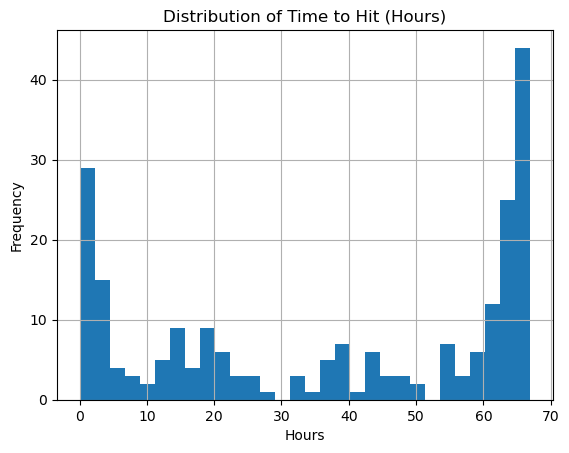

In [45]:
# Visualize 
import matplotlib.pyplot as plt

train["time_to_hit_hours"].hist(bins=30)
plt.title("Distribution of Time to Hit (Hours)")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.show()
